In [2]:
import matplotlib.pyplot as plt
import numpy as np

### Relatório de Treinamento: Funções de Recompensa para o AWS DeepRacer

#### Introdução
Para os primeiros testes de treinamento do carro, buscamos inspiração em artigos publicados por participantes de destaque no ranking de corridas do **AWS DeepRacer Virtual Circuit**. Essa abordagem visava otimizar o desenvolvimento de funções de recompensa eficazes, considerando as limitações de créditos para treinamento. 

Selecionamos três publicações de blog que apresentavam implementações simples, porém eficazes, e cujas estratégias se destacaram no desempenho competitivo:

1. **"Craft a Powerful Reward Function for AWS DeepRacer Student League"**
2. **"How I Got Into The Top 2% In AWS DeepRacer"**
3. **"How We Broke Into The Top 1% of the AWS DeepRacer Virtual Circuit"**

#### Estratégias de Recompensa
As ideias exploradas nos artigos compartilhavam algumas similaridades, mas também apresentavam distinções importantes:

1. **Primeiro e segundo artigos:**
   - Ambas as abordagens focavam em recompensar o veículo com base na proximidade do centro da pista, penalizando desvios excessivos.
   - O segundo artigo, entretanto, adicionava um controle mais detalhado, relacionando a distância ao centro com a rotação das rodas do carro, conferindo maior precisão.

2. **Terceiro artigo:**
   - A principal diferença era o uso de informações de estado anteriores na função de recompensa, como velocidade e ângulo de direção. Essa abordagem introduzia uma perspectiva de longo prazo, buscando suavidade e consistência na direção.

#### Implementação e Treinamento
Com base nas ideias e códigos sugeridos pelos blogs, desenvolvemos duas versões de funções de recompensa que combinavam os conceitos mais robustos dos artigos analisados. Os treinamentos foram realizados utilizando **hiperparâmetros padrão** durante **1 hora** na pista **[NOME DA PISTA]**.

#### Primeira Função de Recompensa

A primeira função de recompensa foi projetada para promover uma direção suave, rápida e eficiente, com foco em três aspectos principais: aderência à linha central, controle de velocidade e eficiência no progresso. A função utiliza os seguintes critérios para calcular a recompensa:

1. **Adesão à Linha Central:**
   - O veículo é recompensado de acordo com sua proximidade ao centro da pista. 
   - A recompensa é proporcional à distância, com uma curva que penaliza desvios de forma progressiva.

2. **Controle de Velocidade:**
   - Velocidades ideais são definidas de acordo com a inclinação do ângulo de direção:
     - Para retas (ângulo de direção < 10°): a velocidade alvo é **2.5 m/s**.
     - Para curvas (ângulo de direção ≥ 10°): a velocidade alvo é **1.8 m/s**.
   - Penalidades são aplicadas para discrepâncias significativas entre a velocidade atual e a ideal.

3. **Penalização para Curvas Fechadas com Alta Velocidade:**
   - Um fator de penalização é aplicado se o ângulo de direção exceder 15° enquanto o veículo estiver a velocidades superiores a 1.8 m/s, reduzindo a recompensa final.

4. **Eficiência no Progresso:**
   - A função considera o progresso percentual alcançado em relação ao número de passos dados. Isso incentiva trajetórias eficientes, promovendo uma combinação de velocidade e precisão.

5. **Combinação Ponderada:**
   - Os fatores são combinados com diferentes pesos para equilibrar os critérios:
     - Recompensa de centralidade: **3x**
     - Recompensa de velocidade: **2x**
     - Penalização para curvas fechadas: **1x**
     - Recompensa por progresso: **0.5x**

Os fatores multiplicativos, expoentes e velocidades foram baseados nas implementações das postagens analisadas. Esses parâmetros iniciais poderão ser ajustados futuramente com base no desempenho observado, buscando otimizar a função de recompensa.

In [ ]:
def reward_function(params):
    """
    Função de recompensa para direção suave, rápida e consistente
    """
    # Extrair parâmetros
    track_width = params['track_width']
    distance_from_center = params['distance_from_center']
    steering_angle = params['steering_angle']
    speed = params['speed']
    steps = params['steps']
    progress = params['progress']
    heading = params['heading']
    all_wheels_on_track = params['all_wheels_on_track']

    # Penalização por sair da pista
    if not all_wheels_on_track:
        return 1e-3

    # Recompensa por adesão à linha central
    center_reward = max(1e-3, 1 - (distance_from_center / (0.5 * track_width))**0.4)

    # Penalização para curvas muito fechadas e alta velocidade
    if abs(steering_angle) > 15 and speed > 1.8:
        steering_penalty = 0.5  # Reduz recompensa em curvas fechadas com alta velocidade
    else:
        steering_penalty = 1.0

    # Recompensa por velocidade ideal de acordo com o ângulo
    if abs(steering_angle) < 10:  # Retas
        speed_reward = max(1e-3, 1 - abs(speed - 2.5) / 2.5)

    else:  # Curvas
        speed_reward = max(1e-3, 1 - abs(speed - 1.8) / 1.8)

    # Recompensa por progresso (proporcional à eficiência dos passos)
    progress_reward = (progress / steps) * 10 if steps > 0 else 0

    # Combinação ponderada das recompensas
    reward = (center_reward * 3) + (speed_reward * 2) + (steering_penalty) + (progress_reward * 0.5)

    return float(reward)


#### Segunda Função de Recompensa

A segunda função de recompensa foi projetada com foco em promover **consistência no comportamento do veículo**, incorporando informações do estado anterior para suavizar transições e penalizar ações abruptas. Essa abordagem considera três critérios principais: centralidade, consistência na velocidade e suavidade nas curvas.

1. **Adesão à Linha Central:**
   - Assim como na primeira função, o veículo é recompensado de acordo com a proximidade ao centro da pista, penalizando desvios de forma progressiva.

2. **Consistência na Velocidade:**
   - A função compara a velocidade atual com a anterior para penalizar mudanças bruscas. Isso incentiva o carro a manter um ritmo constante, mesmo em diferentes trechos da pista.

3. **Suavidade nas Curvas:**
   - A função avalia a mudança no ângulo de direção entre estados consecutivos. Mudanças bruscas no ângulo são penalizadas, incentivando curvas mais suaves.

4. **Penalidade para Ações Críticas:**
   - Caso uma ação "imperdoável" ocorra, como sair da pista, uma penalidade severa é aplicada, reduzindo a recompensa para o valor mínimo possível.

5. **Combinação Ponderada:**
   - Os critérios são combinados com pesos para equilibrar os objetivos:
     - Recompensa de centralidade: **2x**
     - Recompensa de consistência na velocidade: **3x**
     - Recompensa de suavidade nas curvas: **2x**

In [32]:
class PARAMS:
    """
    Classe para armazenar o estado anterior dos parâmetros de condução.
    """
    prev_speed = None  # Velocidade anterior do veículo
    prev_steering_angle = None  # Ângulo de direção anterior
    prev_direction_diff = None  # Diferença de direção anterior (não usada no código atual)
    prev_normalized_distance_from_route = None  # Distância anterior normalizada ao centro da rota
    unpardonable_action = False  # Flag para ações críticas não perdoadas

def reward_function(params):

    # Extrai os parâmetros fornecidos
    track_width = params['track_width']
    distance_from_center = params['distance_from_center']
    steering_angle = params['steering_angle']
    speed = params['speed']
    all_wheels_on_track = params['all_wheels_on_track']

    # Penaliza se o carro sair da pista
    if not all_wheels_on_track:
        return 1e-3

    # Calcula a recompensa baseada na proximidade do centro da pista
    center_reward = max(1e-3, 1 - (distance_from_center / (0.5 * track_width))**0.4)

    # Calcula a recompensa para consistência na velocidade
    if PARAMS.prev_speed is not None:
        speed_diff = abs(speed - PARAMS.prev_speed)
        speed_reward = max(1e-3, 1 - speed_diff / 2)  # Penaliza variações grandes de velocidade

    else:
        speed_reward = 1.0

    # Calcula a recompensa para suavidade nas curvas
    if PARAMS.prev_steering_angle is not None:
        steering_change = abs(steering_angle - PARAMS.prev_steering_angle)
        steering_reward = max(1e-3, 1 - steering_change / 15)  # Penaliza mudanças bruscas na direção
        
    else:
        steering_reward = 1.0

    # Combina as recompensas ponderadas
    reward = (center_reward * 2) + (speed_reward * 3) + (steering_reward * 2)

    # Aplica penalidade caso tenha ocorrido uma ação crítica não perdoável
    if PARAMS.unpardonable_action:
        reward = 1e-3

    # Atualiza o estado anterior com os valores atuais
    PARAMS.prev_speed = speed
    PARAMS.prev_steering_angle = steering_angle
    PARAMS.prev_normalized_distance_from_route = distance_from_center

    return float(reward)

No final do treinamento, a primeira versão, mais simples, superou a segunda com um *Average Percentage Completion (Evaluating)* de **52,6%**, contra aproximadamente **30%** da segunda. Com base nesses resultados, decidimos focar em criar variações do modelo inicial para aprimorá-lo.

O primeiro passo foi analisar cada componente da função de recompensa com mais atenção. Para a penalização da distância do carro à linha central, assim como na abordagem do autor 1, optamos por utilizar uma função exponencial. O gráfico a seguir ilustra como o reward varia com diferentes valores de expoentes:

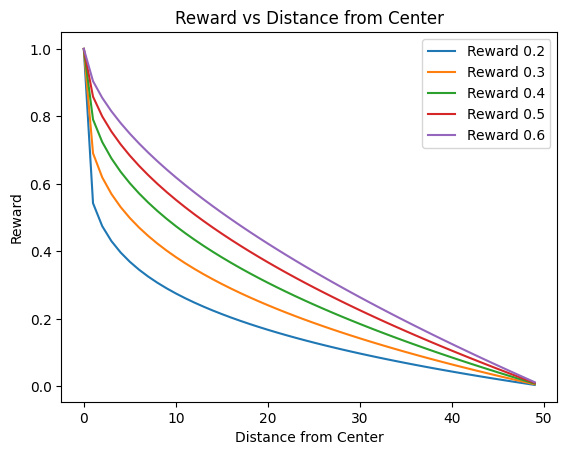

In [3]:
track_width = 1

disocunts = [0.2, 0.3, 0.4, 0.5, 0.6]

for discount in disocunts:
    cur_list= []
    for distance_from_center in range(0, 50, 1):
        cur_list.append( 1 - (distance_from_center/100 / (0.5 * track_width))**discount)

    plt.plot(cur_list)

plt.xlabel('Distance from Center')
plt.ylabel('Reward')
plt.title('Reward vs Distance from Center')
plt.legend([f'Reward {i}' for i in disocunts])
plt.show()

Considerando que o expoente **0,4** apresentou uma penalização adequada, decidimos mantê-lo como valor inicial. Além disso, durante a avaliação da função anterior, o carro não apresentou desvios inesperados no comportamento, o que reforçou a decisão de manter essa escolha.

O segundo componente analisado foi a penalização por velocidade, ajustada com base no ângulo das rodas. Esse ajuste ajuda a manter o carro mais lento em curvas, reduzindo o risco de sair da pista. O gráfico abaixo demonstra como a recompensa varia para diferentes limites de velocidade:

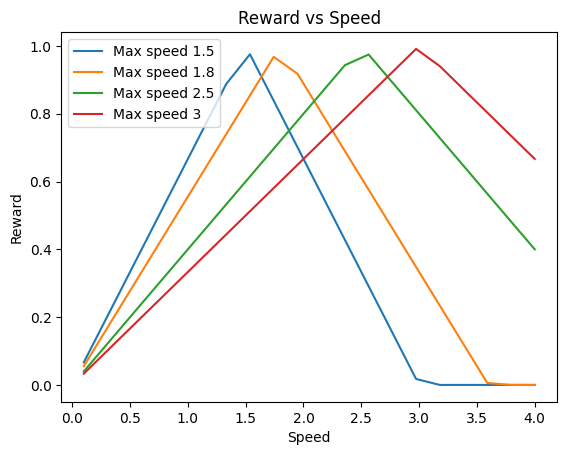

In [33]:
import numpy as np

reward_list = []

possible_speed = np.linspace(0.1, 4.0, 20)
possible_max =[1.5, 1.8,2.5,3]

for max_speed in possible_max:
    speed_reward = []

    for speed in possible_speed:

        speed_reward.append(max(0, 1 - (abs(speed - max_speed) / max_speed)))
        
    plt.plot(possible_speed,speed_reward)

plt.xlabel('Speed')
plt.ylabel('Reward')
plt.title('Reward vs Speed')
plt.legend([f'Max speed {i}' for i in possible_max])
plt.show()

Optamos, inicialmente, por seguir as recomendações dos autores para as velocidades máximas, mas realizamos um ajuste após identificar que o carro frequentemente saía da pista durante a avaliação do modelo. Assim, mantivemos a velocidade de **2,5** para ângulos menores que |5| e reduzimos para **1,5** (em vez de 1,8) para ângulos maiores que |15|. Para ângulos intermediários, a velocidade é livre, proporcionando maior flexibilidade em trechos retos

Por fim, ajustamos a função que relaciona o número de passos (*steps*) com o progresso. Após analisar os logs das corridas anteriores, em que foram utilizados **386 passos** para completar **50%** da pista, desenvolvemos uma nova abordagem. Considerando um número esperado de **700 passos** para completar a volta, implementamos uma função exponencial que compara o número real de passos com o esperado, dado o progresso atual. Essa função recompensa de forma significativa quando a expectativa é superada e aplica a recompensa mínima se for igual ou inferior.

Além de mais intuitiva, essa nova versão varia entre **0** e **1**, facilitando a atribuição de pesos distintos para cada componente da recompensa total em versões futuras. 

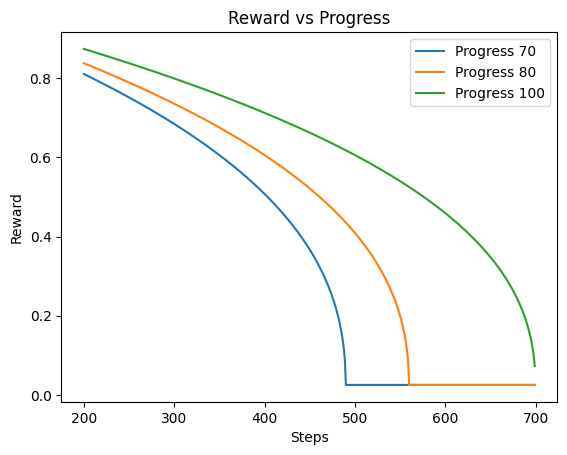

In [31]:
expected_steps= 700
progress_list = [70, 80, 100]
min_reward= 0.0001
steps_list = range(200,700)


for progress in progress_list:
    steps_reward = []
    for steps  in steps_list:

        expected_steps_progress = expected_steps * (progress / 100) #numero de passos esperados para o progresso atual

        if expected_steps_progress > 0:
            progress_reward = max(min_reward,  (expected_steps_progress - steps)/expected_steps_progress  )**0.4
            
        else: progress_reward =0 

        steps_reward.append(progress_reward)

    plt.plot(steps_list,steps_reward)


plt.xlabel('Steps')
plt.ylabel('Reward')
plt.title('Reward vs Progress')
plt.legend([f'Progress {i}' for i in progress_list])
plt.show()



Finalmente, é mantida a recompensa mínima caso todas as rodas saiam da pista. Unindo todas essas partes, a primeira função que testamos:

In [ ]:
def reward_function(params):
    """
    Função de recompensa para direção suave, rápida e consistente
    """
    
    # Extrair parâmetros
    track_width = params['track_width']   # largura da pista
    distance_from_center = params['distance_from_center'] # distância do centro da pista
    steering_angle = params['steering_angle'] # ângulo de direção do carro
    speed = params['speed'] # velocidade do carro
    steps = params['steps'] # número de passos tomados (0:Nstep)
    progress = params['progress'] # progresso do carro ao longo da pista (0:100)
    all_wheels_on_track = params['all_wheels_on_track'] # se o carro está na pista

    min_reward = 1e-5
    expected_steps = 700 #baseado em treinamentos anteriores 

    # Penalização por sair da pista
    if not all_wheels_on_track:
        return min_reward

    # Recompensa por adesão à linha central
    center_reward = max(min_reward, 1 - (distance_from_center / (0.5 * track_width))**0.4)

    # Recompensa por direção suave / rápida dependendo do angulo de direção

    if abs(steering_angle) > 15: #angulo maior que 15, velocidade maxima de 1.5
        speed_reward = max(min_reward, 1 - (abs(speed - 1.5) / 1.5))

    elif abs(steering_angle) > 5: #angulo maior que 5, velocidade maxima de 2.5
        speed_reward = max(min_reward, 1 - (abs(speed - 2.5) / 2.5))

    else: #angulos de até 5, velocidade maxima configurada
        speed_reward = 1

    # Recompensa por progresso (proporcional à eficiência dos passos)
    expected_steps_progress = expected_steps * (progress / 100) #numero de passos esperados para o progresso atual
    
    if expected_steps_progress > 0:
        progress_reward = max(min_reward,  (expected_steps_progress - steps)/expected_steps_progress  )**0.4
    else: progress_reward =0 

    # Combinação ponderada das recompensas (todos variam de 0 a 1)
    reward = (center_reward) + (speed_reward) + (progress_reward)

    return float(reward)


Essa versão da função superou bastante as demais, atingindo um **Average percentage completion (Evaluating)** de cerca de **64%** com 1h de treinamento. Como obteve uma performance muito boa e, com base no gráfico de treino, ainda há espaço para melhorias (já que a recompensa ainda não se estabilizou), decidimos continuar o treinamento por mais **3 horas**. Com isso, conseguimos um **Average percentage completion (Evaluating)** superior a **96%**.

![Função de reward treinada por 1h](img/treinamento_1h.jpg)

Com esses resultados promissores, decidimos explorar pequenas variações desse modelo, como ajustar a velocidade máxima para cada ângulo, modificar as velocidades máximas do carro e testar diferentes pesos na recompensa ponderada. Essas mudanças foram feitas clonando o modelo treinado, para evitar que o próximo treinamento começasse do zero.

As melhores versões obtidas foram a original com total de 4h de treinamento e **96%** de **Average percentage completion (Evaluating)**, conquistando o 108º posição da corrida atual na pista convencional, terminando as 3 voltas em 16s. E uma versão semelhante, treinada como clone desta última mas com o dobro de peso para **speed_reward** e **progress_reward**, que apesar de ter tido menor percentual no **Average percentage completion (Evaluating)** foi mais rápido na pista convencional da corrida, levando 14 segundos para completar as 3 voltas e ficado em 4º lugar no ranking Brasil e 72º no mundial, até o dia 07/12. 

![Ranking mundial da corrida atual](img/ranking.jpg)